# Data Science 1, Winter Semester 2021/22
---
# Exercise Sheet 3: Association Rules

Please run the script `prepare_groceries_dataset.py` first and put the two resulting files (`groceries.csv` and `groceries_structure.csv`) into the same folder as this notebook.

## a) Transaction Data

Let's look at the first lines of the file:

In [1]:
with open('groceries.csv') as file:
    for _ in range(10):
        print(file.readline())

citrus fruit,semi-finished bread,margarine,ready soups

tropical fruit,yogurt,coffee

whole milk

pip fruit,yogurt,cream cheese ,meat spreads

other vegetables,whole milk,condensed milk,long life bakery product

whole milk,butter,yogurt,rice,abrasive cleaner

rolls/buns

other vegetables,UHT-milk,rolls/buns,bottled beer,liquor (appetizer)

pot plants

whole milk,cereals



Looks like each line is a transaction and contains comma-separated items.
With this knowledge, we can easily build a transaction list and view the first few transactions:

In [2]:
with open('groceries.csv') as file:
    transaction_ls = [line.replace('\n', '').split(',') for line in file]
print(transaction_ls[:5])

[['citrus fruit', 'semi-finished bread', 'margarine', 'ready soups'], ['tropical fruit', 'yogurt', 'coffee'], ['whole milk'], ['pip fruit', 'yogurt', 'cream cheese ', 'meat spreads'], ['other vegetables', 'whole milk', 'condensed milk', 'long life bakery product']]


This list-of-list structure may not be that comfortable to work with (compared to a table/matrix), but should suffice for now.
We just need to apply list comprehensions to obtain some of the desired summary statistics:

In [3]:
print('Number of transactions in the dataset:', len(transaction_ls))
flat_transaction_ls = [item for transaction in transaction_ls for item in transaction]
print('Number of items in the dataset (summed over transactions):', len(flat_transaction_ls))
print('Number of different items in the dataset:', len(set(flat_transaction_ls)))

Number of transactions in the dataset: 9835
Number of items in the dataset (summed over transactions): 43367
Number of different items in the dataset: 169


To analyze transactions lengths, we first need to extract them.
Next, we can either count them ourselves:

In [4]:
import pandas as pd

lengths = pd.Series([len(transaction) for transaction in transaction_ls])
length_df = lengths.value_counts().rename('frequency').rename_axis(index='length').reset_index()
length_df.sort_values(by='length')

,length,frequency
0,1,2159
1,2,1643
2,3,1299
3,4,1005
4,5,855
5,6,645
6,7,545
7,8,438
8,9,350
9,10,246


... or we leave this job to a histogram:

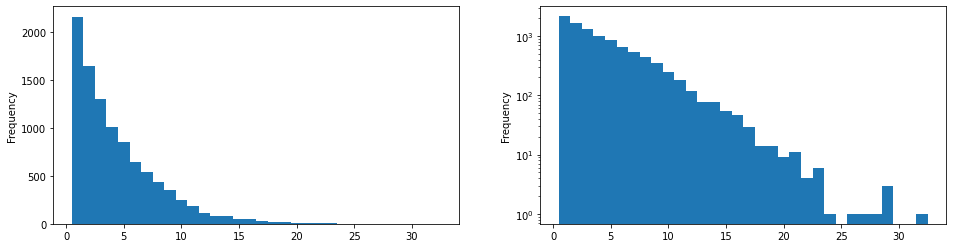

In [5]:
import matplotlib.pyplot as plt

binning = [0.5 + x for x in range(max(lengths) + 1)]  # put (discrete) lengths in middle of bins
fig, axs = plt.subplots(ncols=2, figsize=(16, 4))
lengths.plot.hist(ax=axs[0], bins=binning)
lengths.plot.hist(ax=axs[1], bins=binning, log=True)
plt.show()

We can see that smaller transactions are more common.
In fact, the frequency drops roughly exponentially (i.e., roughly linearly on a log axis) with increasing size of the transaction.

The analysis of item frequencies works similar:

In [6]:
pd.Series(flat_transaction_ls).value_counts().rename('frequency').rename_axis(index='item').reset_index()

,item,frequency
0,whole milk,2513
1,other vegetables,1903
2,rolls/buns,1809
3,soda,1715
4,yogurt,1372
...,...,...
164,bags,4
165,kitchen utensil,4
166,preservation products,2
167,baby food,1


## b) Frequent Itemset Mining

According to the [documentation](http://rasbt.github.io/mlxtend/api_subpackages/mlxtend.frequent_patterns/), the function `apriori()` requires the transaction data to be in a one-hot-encoded `pd.DataFrame`.
One-hot means that there should be a matrix of zeros and ones (false and true):
For each transaction, each item is either present or not.
We can use a `TransactionEncoder` to do the necessary conversion for us.

In [7]:
from mlxtend.preprocessing import TransactionEncoder

encoder = TransactionEncoder()
transaction_array = encoder.fit_transform(X=transaction_ls)
transaction_df = pd.DataFrame(transaction_array, columns=encoder.columns_)
transaction_df.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


This encoder has a similar syntax as pre-processing routines in `sklearn`.
The function `fit_transform()` combines `fit()` and `transform()` into one call.

Given these encoded transactions, applying the Apriori algorithm to determine frequent itemsets is only a matter of one function call:

In [8]:
from mlxtend.frequent_patterns import apriori

frequent_itemsets = apriori(transaction_df, min_support=0.05, use_colnames=True)
print('Number of frequent itemsets:', len(frequent_itemsets))
frequent_itemsets.sort_values(by='support', ascending=False)

Number of frequent itemsets: 31


,support,itemsets
26,0.255516,(whole milk)
15,0.193493,(other vegetables)
19,0.183935,(rolls/buns)
23,0.174377,(soda)
27,0.139502,(yogurt)
2,0.110524,(bottled water)
20,0.108998,(root vegetables)
24,0.104931,(tropical fruit)
22,0.098526,(shopping bags)
21,0.093950,(sausage)


By the way, `mlxtend` also provides an implementation of FP-growth, which (as expected) finds the same itemsets:

In [9]:
from mlxtend.frequent_patterns import fpgrowth

frequent_itemsets = fpgrowth(transaction_df, min_support=0.05, use_colnames=True)
print('Number of frequent itemsets:', len(frequent_itemsets))
frequent_itemsets.sort_values(by='support', ascending=False)

Number of frequent itemsets: 31


,support,itemsets
5,0.255516,(whole milk)
7,0.193493,(other vegetables)
9,0.183935,(rolls/buns)
14,0.174377,(soda)
2,0.139502,(yogurt)
11,0.110524,(bottled water)
19,0.108998,(root vegetables)
3,0.104931,(tropical fruit)
22,0.098526,(shopping bags)
21,0.093950,(sausage)


To get the maximal frequent itemsets, we need to filter out the itemsets that are subsets of any other itemset in the list of frequent itemsets.
Unfortunately, `apriori()` itself cannot do this job for us.
The only additional constraint it allows (besides the support threshold) is a limit on the length of the itemsets.
However, we can easily filter out itemsets ourselves:

In [10]:
max_frequent_ls = [itemset for itemset in frequent_itemsets['itemsets']
                   if not any([itemset < reference_set for reference_set in frequent_itemsets['itemsets']])]

We simply iterate over all itemsets in an outer loop (list comprehension).
In an inner loop (list comprehension), we iterate over all itemsets again.
We use the `<` operator to check if one set is a proper subset of another set.

Let's put the resulting list into a `pd.DataFrame`, just like the one we have received as result of `apriori()`: 

In [11]:
max_frequent_itemsets = (pd.DataFrame({'itemsets': max_frequent_ls})
                         .merge(frequent_itemsets, on='itemsets', how='inner') # re-attach support
                         .reset_index(drop=True))
print('Number of maximal frequent itemsets:', len(max_frequent_itemsets))
max_frequent_itemsets.sort_values(by='support', ascending=False)

Number of maximal frequent itemsets: 27


,itemsets,support
10,(soda),0.174377
7,(bottled water),0.110524
15,(root vegetables),0.108998
2,(tropical fruit),0.104931
18,(shopping bags),0.098526
17,(sausage),0.093950
14,(pastry),0.088968
0,(citrus fruit),0.082766
6,(bottled beer),0.080529
12,(newspapers),0.079817


The number of maximal frequent itemsets is lower than the number of frequent itemsets.
Here, we had some itemsets of size one that were part of frequent itemsets of size two.
For example, `(whole milk)` is frequent, but not maximal frequent, as `(whole milk, other vegetables)` is frequent, too.

As an alternative to our manual filtering, we can use `fpmax()` from `mlxtend`.
This function finds maximal frequent itemsets with an FP-tree.

In [12]:
from mlxtend.frequent_patterns import fpmax

max_frequent_itemsets = fpmax(transaction_df, min_support=0.05, use_colnames=True)
print('Number of maximal frequent itemsets:', len(max_frequent_itemsets))
max_frequent_itemsets.sort_values(by='support', ascending=False)

Number of maximal frequent itemsets: 27


,support,itemsets
24,0.174377,(soda)
22,0.110524,(bottled water)
21,0.108998,(root vegetables)
20,0.104931,(tropical fruit)
19,0.098526,(shopping bags)
18,0.093950,(sausage)
17,0.088968,(pastry)
16,0.082766,(citrus fruit)
15,0.080529,(bottled beer)
14,0.079817,(newspapers)


## c) Association Rule Mining

`association_rules()` takes frequent itemsets, as determined by `apriori()`, as an input.
Thus, we determine itemsets with the support threshold first, and mine association rules with the required confidence second.

In [13]:
from mlxtend.frequent_patterns import association_rules

frequent_itemsets = apriori(transaction_df, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.4)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(beef),(whole milk),0.052466,0.255516,0.021251,0.405039,1.585180,0.007845,1.251315
1,(butter),(whole milk),0.055414,0.255516,0.027555,0.497248,1.946053,0.013395,1.480817
2,(butter milk),(whole milk),0.027961,0.255516,0.011591,0.414545,1.622385,0.004447,1.271634
3,(chicken),(other vegetables),0.042908,0.193493,0.017895,0.417062,2.155439,0.009593,1.383521
4,(chicken),(whole milk),0.042908,0.255516,0.017590,0.409953,1.604411,0.006627,1.261736
...,...,...,...,...,...,...,...,...,...
57,"(yogurt, rolls/buns)",(whole milk),0.034367,0.255516,0.015557,0.452663,1.771563,0.006775,1.360192
58,"(root vegetables, tropical fruit)",(whole milk),0.021047,0.255516,0.011998,0.570048,2.230969,0.006620,1.731553
59,"(yogurt, root vegetables)",(whole milk),0.025826,0.255516,0.014540,0.562992,2.203354,0.007941,1.703594
60,"(yogurt, tropical fruit)",(whole milk),0.029283,0.255516,0.015150,0.517361,2.024770,0.007668,1.542528


The output of `association_rules()` by default includes the values of several metrics for each rule.
However, there is no dedicated routine to post-process the rules according to given constraints.
Thus, we filter the rules manually to answer the two questions from the exercise sheet.
(The R package `apriori` does support mining with constraints.)

First, we are asked for the five rules with the highest confidence:

In [14]:
rules.sort_values(by='confidence', ascending=False).head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
28,"(root vegetables, citrus fruit)",(other vegetables),0.017692,0.193493,0.010371,0.586207,3.029608,0.006948,1.949059
43,"(root vegetables, tropical fruit)",(other vegetables),0.021047,0.193493,0.012303,0.584541,3.020999,0.008231,1.941244
32,"(yogurt, curd)",(whole milk),0.017285,0.255516,0.010066,0.582353,2.279125,0.005649,1.782567
26,"(other vegetables, butter)",(whole milk),0.020031,0.255516,0.011490,0.573604,2.244885,0.006371,1.745992
58,"(root vegetables, tropical fruit)",(whole milk),0.021047,0.255516,0.011998,0.570048,2.230969,0.006620,1.731553


Second, let's see the rules containing `yogurt` in the antecedent with over 50% confidence:

In [15]:
rules[({'yogurt'} <= rules['antecedents']) & (0.5 < rules['confidence'])]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
32,"(yogurt, curd)",(whole milk),0.017285,0.255516,0.010066,0.582353,2.279125,0.005649,1.782567
54,"(yogurt, other vegetables)",(whole milk),0.043416,0.255516,0.022267,0.512881,2.007235,0.011174,1.528340
59,"(yogurt, root vegetables)",(whole milk),0.025826,0.255516,0.014540,0.562992,2.203354,0.007941,1.703594
60,"(yogurt, tropical fruit)",(whole milk),0.029283,0.255516,0.015150,0.517361,2.024770,0.007668,1.542528
61,"(yogurt, whipped/sour cream)",(whole milk),0.020742,0.255516,0.010880,0.524510,2.052747,0.005580,1.565719


Note we're using the subset operator `<=` again, which also allows to check the presence of one set (i.e., `{'yogurt'}`) element-wise for a `pandas.Series` of sets (i.e., `rules['antecedents']`).

## d) Multi-Level Mining

The original dataset from the R packages `arules` comes with three levels (= nested categories) of items.
Before, we only worked with the `label`s, the lowest level.
To use the whole hierarchy, we need to import the structure of the data, supplied to you as `groceries_structure.csv`.

In [16]:
structure_df = pd.read_csv('groceries_structure.csv')
structure_df

,label,level1,level2
0,frankfurter,meat and sausage,sausage
1,sausage,meat and sausage,sausage
2,liver loaf,meat and sausage,sausage
3,ham,meat and sausage,sausage
4,meat,meat and sausage,sausage
...,...,...,...
164,pot plants,non-food,garden
165,flower soil/fertilizer,non-food,garden
166,flower (seeds),non-food,garden
167,shopping bags,non-food,bags


In [17]:
structure_df.nunique()

label     169
level1     10
level2     55
dtype: int64

The dataset encompasses 169 different items according to `label`.
One level up the hierarchy, `level2` combines these into 55 categories.
`level1` represents a more coarse grouping, summarizing the 55 `level2` categories into 10 `level1` categories.

Let's aggregate the item labels:

In [18]:
mapping = structure_df.set_index('label').to_dict()['level2']
agg_transaction_ls = [list({mapping[item] for item in transaction}) for transaction in transaction_ls]
agg_transaction_ls[:5]

[['vinegar/oils', 'fruit', 'bread and backed goods', 'soups/sauces'],
 ['fruit', 'dairy produce', 'coffee'],
 ['dairy produce'],
 ['cheese', 'fruit', 'dairy produce', 'meat spreads'],
 ['shelf-stable dairy',
  'dairy produce',
  'vegetables',
  'long-life bakery products']]

To aggregate our transaction dataset to `level2`, we first create a dictionary for mapping:
Entries of `label` form the keys, the corresponding `level2` entries are the values.
In one transaction, several items may belong to the same `level2` category.
For example, the transaction `['whole milk', 'butter', 'yogurt']` only consists of elements with the `level2` value `dairy produce`.
Thus, we put the `level2` transaction into a set first (note the curly braces) before creating a `list()` again.

The next steps are analogous to the subtasks before:

In [19]:
agg_encoder = TransactionEncoder()
agg_transaction_array = agg_encoder.fit_transform(agg_transaction_ls)
agg_transaction_df = pd.DataFrame(agg_transaction_array, columns=agg_encoder.columns_)
agg_transaction_df.head()

,baby food,bags,bakery improver,bathroom cleaner,beef,beer,bread and backed goods,candy,canned fish,canned fruit/vegetables,...,shelf-stable dairy,snacks,soap,soups/sauces,staple foods,sweetener,tea/cocoa drinks,vegetables,vinegar/oils,wine
0,False,False,False,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,True,False,False


Note how we have the same number of rows (transactions), but only 55 columns (items, resp. `level2` values).

In [20]:
agg_frequent_itemsets = apriori(agg_transaction_df, min_support=0.1, use_colnames=True)
agg_rules = association_rules(agg_frequent_itemsets, metric='confidence', min_threshold=0.4)
agg_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(dairy produce),(bread and backed goods),0.443010,0.345501,0.187697,0.423686,1.226295,0.034637,1.135664
1,(bread and backed goods),(dairy produce),0.345501,0.443010,0.187697,0.543261,1.226295,0.034637,1.219493
2,(fruit),(bread and backed goods),0.249110,0.345501,0.107575,0.431837,1.249886,0.021507,1.151956
3,(sausage),(bread and backed goods),0.189120,0.345501,0.103610,0.547849,1.585668,0.038268,1.447525
4,(vegetables),(bread and backed goods),0.273005,0.345501,0.116218,0.425698,1.232120,0.021894,1.139644
5,(fruit),(dairy produce),0.249110,0.443010,0.156380,0.627755,1.417024,0.046022,1.496301
6,(non-alc. drinks),(dairy produce),0.317946,0.443010,0.151906,0.477774,1.078474,0.011053,1.066570
7,(sausage),(dairy produce),0.189120,0.443010,0.107372,0.567742,1.281557,0.023589,1.288560
8,(vegetables),(dairy produce),0.273005,0.443010,0.170412,0.624209,1.409018,0.049468,1.482179
9,(fruit),(vegetables),0.249110,0.273005,0.107067,0.429796,1.574318,0.039058,1.274974


Though we basically work with the same transactions, we have much higher supports of the mined rules than before.
This is a trivial consequence of merging multiple items to the same category, making the item matrix less sparse.
Thus, it makes sense to increase the support threshold when mining on higher levels.

## e) Level-Crossing Mining

Since we already have one representation of the transactions containing the `label`s and one containing the respective `level2` values, we can simply merge these two lists of lists element-wise.
However, there is some overlap between `label` and `level2` values, i.e., there intersection is not empty:

In [21]:
len(set(structure_df['label']).intersection(set(structure_df['level2'])))

19

We avoid these name clashes by appending a `*` to the `level2` categories when creating the level-crossing representation:

In [22]:
cross_transaction_ls = [basic_ls + [level2_val + '*' for level2_val in agg_ls]
                        for (basic_ls, agg_ls) in zip(transaction_ls, agg_transaction_ls)]
cross_transaction_ls[:5]

[['citrus fruit',
  'semi-finished bread',
  'margarine',
  'ready soups',
  'vinegar/oils*',
  'fruit*',
  'bread and backed goods*',
  'soups/sauces*'],
 ['tropical fruit', 'yogurt', 'coffee', 'fruit*', 'dairy produce*', 'coffee*'],
 ['whole milk', 'dairy produce*'],
 ['pip fruit',
  'yogurt',
  'cream cheese ',
  'meat spreads',
  'cheese*',
  'fruit*',
  'dairy produce*',
  'meat spreads*'],
 ['other vegetables',
  'whole milk',
  'condensed milk',
  'long life bakery product',
  'shelf-stable dairy*',
  'dairy produce*',
  'vegetables*',
  'long-life bakery products*']]

Again, we need to one-hot encode the transaction matrix first and extract the association rules second:

In [23]:
cross_encoder = TransactionEncoder()
cross_transaction_arr = cross_encoder.fit_transform(cross_transaction_ls)
cross_transaction_df = pd.DataFrame(cross_transaction_arr, columns=cross_encoder.columns_)

cross_frequent_itemsets = apriori(cross_transaction_df, min_support=0.1, use_colnames=True)
cross_rules = association_rules(cross_frequent_itemsets, metric='confidence', min_threshold=0.4)
cross_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(bottled water),(non-alc. drinks*),0.110524,0.317946,0.110524,1.000000,3.145187,0.075383,inf
1,(bread and backed goods*),(dairy produce*),0.345501,0.443010,0.187697,0.543261,1.226295,0.034637,1.219493
2,(dairy produce*),(bread and backed goods*),0.443010,0.345501,0.187697,0.423686,1.226295,0.034637,1.135664
3,(fruit*),(bread and backed goods*),0.249110,0.345501,0.107575,0.431837,1.249886,0.021507,1.151956
4,(bread and backed goods*),(rolls/buns),0.345501,0.183935,0.183935,0.532372,2.894350,0.120385,1.745116
5,(rolls/buns),(bread and backed goods*),0.183935,0.345501,0.183935,1.000000,2.894350,0.120385,inf
6,(sausage*),(bread and backed goods*),0.189120,0.345501,0.103610,0.547849,1.585668,0.038268,1.447525
7,(vegetables*),(bread and backed goods*),0.273005,0.345501,0.116218,0.425698,1.232120,0.021894,1.139644
8,(whole milk),(bread and backed goods*),0.255516,0.345501,0.114184,0.446876,1.293416,0.025903,1.183278
9,(fruit*),(dairy produce*),0.249110,0.443010,0.156380,0.627755,1.417024,0.046022,1.496301


In the rules, we see a lot `level2` categories (note the `*`), as they have an advantage in meeting the support threshold.
This is a general challenge in level-crossing mining.
Also, we notice rules involving items and their categories, e.g. `(tropical fruit) -> (fruit*)`, which trivially achieve a confidence of 1.
What could also happen, but what we don’t have here (because of the support threshold) is that a similar rule appears as a low-level version and a high-level version
(e.g., imagine `(tropical fruit) -> (milk)` and `(fruit*) -> (dairy produce*)`).
Some additional post-processing would be necessary to filter out such redundant rules.